# Dynamic Convolutional Neural Network
***
# Table of Contents
1.   [Imports](#Imports)
2.   [Dataset Object](#Dataset-Object)
3.   [Data Loading](#Data-Loading)
4.   [Model](#Model)
5.   [Setup](#Setup)
6.   [Training](#Training)
7.   [Testing](#Testing)

# Imports

The necessary libraries are imported at this stage.

* torch - Python pytorch library used to create and train the CNN
* numpy - Efficient data arrays
* pandas - Data applications
* sklearn - Provides a number of models, metrics and general functionality for machine learning.
* matplotlib - Provides plotting.

In [1]:
import torch
import numpy as np
import pandas as pd
from torch.nn import Linear, Conv1d, MaxPool1d, Module, CrossEntropyLoss, Dropout
from torch.optim import Adam
from torch.utils.data import Dataset
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, confusion_matrix
import Helper as h

# Dataset Object

Although not fully required it is helpful to create a custom torch.utils.data.Dataset when using the pytorch library.
This makes the splitting and feeding of data into the network easier.

## Encoding

A dict is defined 0-2 for the Dynamic activities in the dataset.

In [2]:
activity_encode =   {
                        "WALKING": 0,
                        "WALKING_DOWNSTAIRS": 1,
                        "WALKING_UPSTAIRS": 2,
                        "LAYING": 3,
                        "SITTING": 4,
                        "STANDING": 5
                    }

## Dataset

The object is defined as below for the UCI dataset. 3 functions need to be implemented **__init__**, **__len__** and
**__getitem__**.

In initialisation the data is split into X and y variables and turned into tensors.

The X variable has shape (row_count, 1, feature_count). 1 since there is only one channel of data.

The static features are removed.

In [3]:
class UCI_Dynamic_Dataset(Dataset):
    """UCI dataset."""

    def __init__(self, csv_file):
        data = pd.read_csv(csv_file)
        data['Activity'] = data['Activity'].map(activity_encode)
        data, _ = [x for _, x in data.groupby(data['Activity'] > 2)]
        self.data_y = data['Activity'].values
        data = pd.DataFrame(data.drop(['Activity','subject'],axis=1))
        self.data_x = np.array(data)
        # [batch, channels, features]
        self.data_x = self.data_x.reshape(len(self.data_x), 1, 561)
        self.data_x  = torch.from_numpy(self.data_x)
        self.data_y = self.data_y.astype(int)
        self.data_y = torch.from_numpy(self.data_y)

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx]

Initialise the 3 datasets that will be used.

In [4]:
train_data = UCI_Dynamic_Dataset(csv_file='UCI Dataset/train.csv')
valid_data = UCI_Dynamic_Dataset(csv_file='UCI Dataset/valid.csv')
test_data = UCI_Dynamic_Dataset(csv_file='UCI Dataset/test.csv')

In [ ]:
h.pie('Our Dataset/train.csv', activity_encode, 2)
h.pie('Our Dataset/valid.csv', activity_encode, 2)
h.pie('Our Dataset/test.csv', activity_encode, 2)

# Data Loading

Using the DataLoader object load in the data, shuffling and assigning a batch size of 64.

In [5]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

# Model

The Dynamic CNN is implemented below, documentation is provided in the report.

In [6]:
class DynamicCNN(Module):
    def __init__(self):
        super(DynamicCNN, self).__init__()

        self.conv1 = Conv1d(1, 100, kernel_size=tuple([3]))
        self.pool =  MaxPool1d(kernel_size=tuple([3]))
        self.fc = Linear(18600, 3)
        self.dropout = Dropout(0.5)

    # Defining the forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 1 * 100 * 186)
        x = self.dropout(F.softmax(self.fc(x), dim=1))
        return x

# Setup

In this step we initialise the loss, optimizer and model objects. For this problem we used cross entropy loss and the
adam optimizer.

If found we use cuda GPU acceleration to make the process faster.

In [7]:
criterion = CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DynamicCNN()
epochs = 10

step = epochs//5
optimizer = Adam(model.parameters(), lr=0.0005)
model.to(device)

DynamicCNN(
  (conv1): Conv1d(1, 100, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=(3,), stride=(3,), padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=18600, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

# Training

In this step the model is trained. Validation is done so we can observe the progress.

In [8]:
data_loaders = {}
data_loaders['train'] = trainloader
data_loaders['val'] = validloader
data_lengths = {"train": len(train_data), "val": len(valid_data)}
for epoch in range(epochs):
    if (epoch+1) % step == 0:
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for data in data_loaders[phase]:
            inputs, labels = data
            inputs, labels = inputs.to(device).float(), labels.to(device).long()
            # forward pass to get outputs
            output = model(inputs)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output, labels)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()

            # print loss statistics
            running_loss += loss.item()

        epoch_loss = running_loss / data_lengths[phase]
        if (epoch+1) % step == 0:
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

Epoch 1/9
----------
train Loss: 0.0131
val Loss: 0.0112
Epoch 3/9
----------
train Loss: 0.0117
val Loss: 0.0104
Epoch 5/9
----------
train Loss: 0.0113
val Loss: 0.0101
Epoch 7/9
----------
train Loss: 0.0111
val Loss: 0.0098
Epoch 9/9
----------
train Loss: 0.0109
val Loss: 0.0097


# Testing

Finally the model is tested on the test set.

In [9]:
model.cpu()
predictions = []
test_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.float(), labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for p in predicted:
            predictions.append(p)

        for l in labels:
            test_labels.append(l)


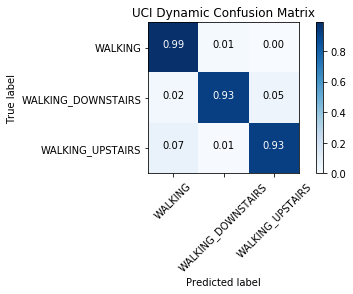

In [10]:
cnf_matrix = confusion_matrix(test_labels, predictions)
np.set_printoptions(precision=2)

classes =   {
                "WALKING":0,
                "WALKING_DOWNSTAIRS":1,
                "WALKING_UPSTAIRS":2,
            }
# Plot non-normalized confusion matrix
h.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='UCI Dynamic Confusion Matrix')


In [11]:
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(test_labels, predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(test_labels, predictions, beta = 0.5,average='weighted')))
print("Final precision score on the testing data: {:.4f}".format(precision_score(test_labels, predictions, average='weighted')))
print("Final recall score on the testing data: {:.4f}".format(recall_score(test_labels, predictions, average='weighted')))



Final accuracy score on the testing data: 0.9488
Final F-score on the testing data: 0.9493
Final precision score on the testing data: 0.9500
Final recall score on the testing data: 0.9488
